In [1]:
import numpy as np
import os
import os.path
import src.visualization.display as dsp
import netCDF4 as nc
import matplotlib.pyplot as plt
import torch
from pytorch_lightning import Trainer,seed_everything,LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import src.unet as unet
import scipy.ndimage.morphology as scm
import importlib
import matplotlib.ticker as mtick

In [2]:
os.getcwd()
os.chdir("../")
os.getcwd()

'/Users/skrunes/Documents/DL-normalization'

In [3]:
with nc.Dataset("data/rando10000.nc","r") as data:
    eps_rnd = data["diff"][:]
    norm = data["norm_coeffs"][:]
    norm_rnd = data["norm_coeffs_rnd"][:]

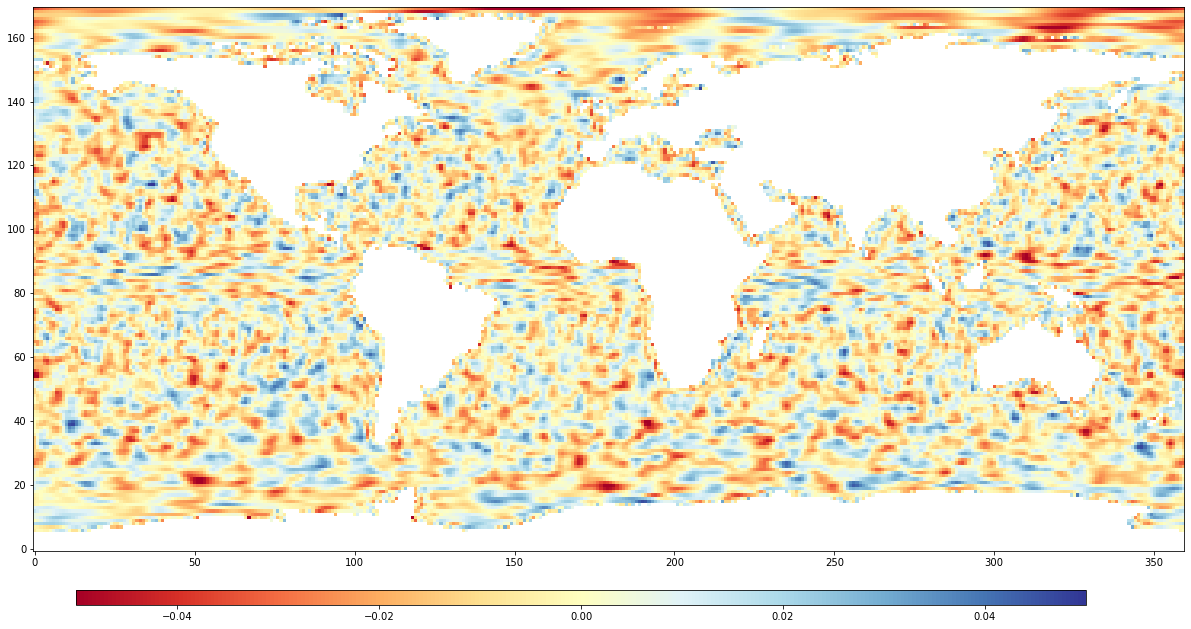

In [4]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(np.roll(eps_rnd[5:-5,:],180,axis=1),origin="lower",vmin=-0.05,vmax=0.05,cmap="RdYlBu")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

In [6]:
model = unet.Unet.load_from_checkpoint("results/wandb/nemovar/2nfvyviz/checkpoints/epoch=889-val_loss=0.00058.ckpt")
X = np.load("data/processed/nemonemo_perten190_samples_standardize/valid/X/NORSSH_PERTEN15.npz")['arr_0']
Y = np.load("data/processed/nemonemo_perten190_samples_standardize/valid/Y/NORSSH_PERTEN15_norm_coeffs.npz")['arr_0']
Y= Y[31:-31,28:-28]
X=torch.from_numpy(X[np.newaxis,:]).float()

std = model.norm_std
mean = model.norm_mean

print(X.shape)

mask = np.where(Y==0,True,False)
Y = Y*std + mean
Y_pred = model.forward(X).detach().numpy()[0,0,31:-31,28:-28]*std + mean
eps = (Y_pred**2 - Y**2)/Y**2
#eps[mask] = 100
eps =np.ma.masked_array(eps, mask)
#mse=((Y_pred - Y)**2)

torch.Size([1, 3, 352, 416])


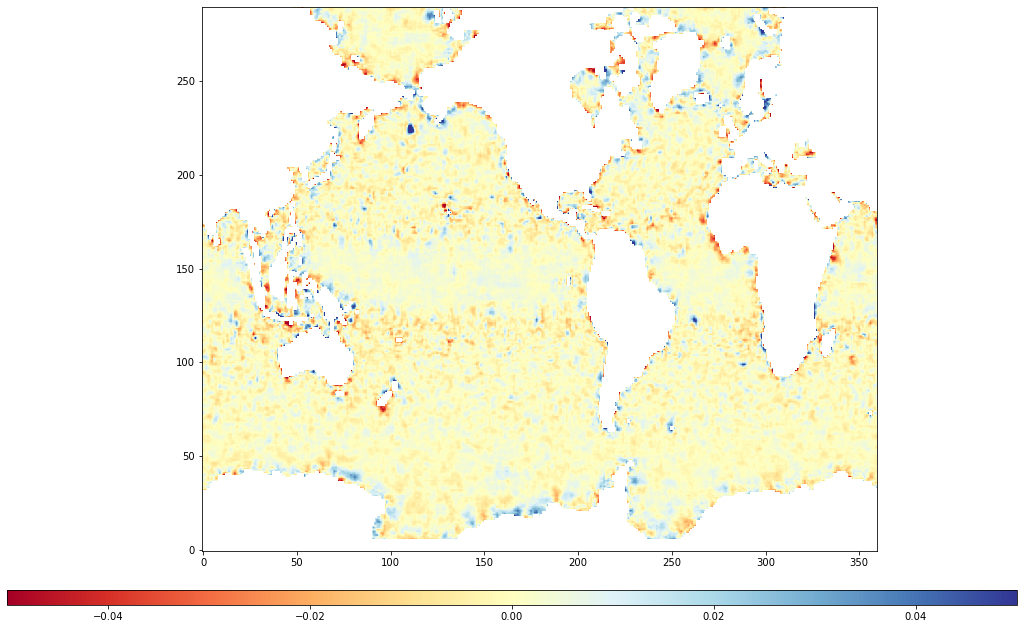

In [7]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(eps,origin="lower",vmin=-0.05,vmax=0.05,cmap="RdYlBu")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()